In [19]:
# If needed, ensure the notebook's working directory is on the import path
import sys
from pathlib import Path

cwd = Path.cwd()
if str(cwd) not in sys.path:
    sys.path.insert(0, str(cwd))

cwd

WindowsPath('c:/Users/17414/OneDrive/桌面/USC/Health_AI_Research/Sythetic Dataset')

In [ ]:
from synthetic_dataset_generator_eric import (
    SyntheticCausalSurvivalParams,
    SyntheticCausalSurvivalDatasetGenerator,
 )

params = SyntheticCausalSurvivalParams(
    seed=123,
    n=5000,
    p=20,
    sigma_z=0.6,
    sigma_v=0.6,
    gamma_u=0.2,
    beta_u=0.2,
    tau=0.2,
    target_censor_rate=0,
    use_random_censoring=False,
 )

gen = SyntheticCausalSurvivalDatasetGenerator(params, verbose=True)
data = gen.generate()

df_observed = data["observed"]
df_hidden = data["hidden"]

df_observed.head()

X shape: (5000, 20)
U shape: (5000,)
Corr(Z, U): 0.8931344601545548
Corr(V, U): 0.8932103405694043
Treatment prevalence (mean W): 0.488
Calibrated administrative censoring time c_admin = 6189.991
Achieved censoring rate = 0.000% (target 0%)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X16,X17,X18,X19,X20,Z,V,W,Y,Delta
0,-0.989121,-0.367787,1.287925,0.193974,0.920231,0.577104,-0.636464,0.541952,-0.316595,-0.322389,...,0.136321,1.532033,-0.659969,-0.311795,0.337769,0.585693,0.443759,0,2475.822482,1
1,-2.207471,0.827921,1.541630,1.126807,0.754770,-0.145978,1.281902,1.074031,0.392621,0.005114,...,0.164380,0.859881,1.761661,0.993324,-0.291521,-2.445571,-2.069215,1,991.205086,1
2,0.728128,-1.261600,1.429939,-0.156475,-0.673759,-0.639060,-0.061361,-0.392785,2.289910,-0.718181,...,-0.583408,-0.862161,-1.488175,0.216307,0.984376,-3.480921,-2.183904,0,1823.033385,1
3,-0.543084,-0.558615,-0.316483,-0.460640,-1.436270,1.365108,0.439000,-0.711695,0.297172,-0.438457,...,-0.248859,-0.499749,0.099598,0.128343,-0.734222,-3.001538,-2.189112,0,733.302258,1
4,-0.620475,0.813274,1.641801,-0.226501,-0.647965,-0.283371,-0.995131,-0.272872,0.422444,-0.081343,...,-1.222346,-0.303591,-1.173689,0.826274,0.850322,-2.774254,-1.998440,0,559.467945,1


In [21]:
df_hidden.head()

,U,T0,T1,T
0,0.401671,2475.822482,2166.773779,2475.822482
1,-1.339852,1132.581472,991.205086,991.205086
2,-1.824246,1823.033385,1595.470178,1823.033385
3,-1.770038,733.302258,641.766571,733.302258
4,-1.530916,559.467945,489.631418,559.467945


# Compute CATE using econml cf, given X, Z, V

In [22]:
from econml.dml import CausalForestDML
import numpy as np

# X: covariates (include original X plus proxies Z, V)
X_col = [f"X{i+1}" for i in range(20)]
X = df_observed[X_col].values

T = df_observed["W"].values

Y = df_observed["Y"].values

print(f"Data shapes: X + Z + V ={df_observed[X_col + ['Z', 'V']].shape}, T={T.shape}, Y={Y.shape}")

# Fit Causal Forest
# Use CausalForestDML which handles confounding via double machine learning
cf = CausalForestDML(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=123
)

print("Fitting Causal Forest...")
cf.fit(Y=Y, T=T, X=df_observed[X_col + ["Z", "V"]].values)

# Predict CATE for all observations
cate_econml_pred = cf.effect(df_observed[X_col + ["Z", "V"]].values)

print(f"CATE predictions shape: {cate_econml_pred.shape}")
print(f"CATE summary: mean={cate_econml_pred.mean():.2f}, std={cate_econml_pred.std():.2f}")
print("econml CATE(X,Z,V) summary (min, median, max):", (float(cate_econml_pred.min()), float(np.median(cate_econml_pred)), float(cate_econml_pred.max())))

Data shapes: X + Z + V =(5000, 22), T=(5000,), Y=(5000,)
Fitting Causal Forest...
CATE predictions shape: (5000,)
CATE summary: mean=-165.57, std=77.98
econml CATE(X,Z,V) summary (min, median, max): (-532.0146976330035, -160.4372973501246, 134.78240844663426)


# Computing true CATE, given X, U

In [23]:
from scipy.special import gamma
    
# E[T(1) - T(0) | X, U]
U = df_hidden["U"].values
    
# Parameters from the generator (fixed defaults)
k_weib = 1.5
lambda0 = 1500.0
beta_u = params.beta_u
tau = params.tau

beta_t = data["model"]["beta_t"]

weibull_mean_const = lambda0 * gamma(1.0 + 1.0 / k_weib)
common_term = weibull_mean_const * np.exp(-(X @ beta_t + beta_u * U) / k_weib)
cate_true = common_term * (np.exp(-tau / k_weib) - 1.0)

print(f"\nTrue CATE summary: mean={cate_true.mean():.2f}, std={cate_true.std():.2f}")


True CATE summary: mean=-172.70, std=34.73


# Computing CATE using eq8, given X, Z, U

In [24]:
b_z = data["model"]["b_z"]
b_v = data["model"]["b_v"]

Z = df_observed["Z"].values
V = df_observed["V"].values

Z_tilde = Z - (X @ b_z)
V_tilde = V - (X @ b_v)

# These should remain strongly correlated with U if proxies are low-noise
print("Corr(Z_tilde, U):", float(np.corrcoef(Z_tilde, U)[0, 1]))
print("Corr(V_tilde, U):", float(np.corrcoef(V_tilde, U)[0, 1]))

Corr(Z_tilde, U): 0.9271716094744806
Corr(V_tilde, U): 0.9273302487121372


In [25]:
a_z = 1.5
a_v = 1.5
sigma_z = params.sigma_z
sigma_v = params.sigma_v

numerator = a_z * (sigma_v ** 2) * Z_tilde + a_v * (sigma_z ** 2) * V_tilde

denominator = (a_z ** 2) * (sigma_v ** 2) + (a_v ** 2) * (sigma_z ** 2) + (sigma_z ** 2) * (sigma_v ** 2)

mu_U_given_ZV = numerator / denominator

var_U_given_ZV = (sigma_z ** 2) * (sigma_v ** 2) / denominator

print("mu_U_given_ZV shape:", mu_U_given_ZV.shape)
print("var_U_given_ZV:", float(var_U_given_ZV))
# correlation between posterior mean and true U (should be high if proxies are informative)
print("Corr(mu_U_given_ZV, U):", float(np.corrcoef(mu_U_given_ZV, U)[0, 1]))

mu_U_given_ZV shape: (5000,)
var_U_given_ZV: 0.07407407407407408
Corr(mu_U_given_ZV, U): 0.9614484594109084


In [26]:
const_term = lambda0 * gamma(1.0 + 1.0 / k_weib)                # lambda * Gamma(1 + 1/k)
x_term = -(1.0 / k_weib) * (X @ beta_t)                         # -(1/k) * beta_t^T X_i
mu_term = -(beta_u / k_weib) * mu_U_given_ZV                    # -(beta_u/k) * mu_{U|Z,V}
var_term = 0.5 * (beta_u**2 / (k_weib**2)) * var_U_given_ZV     # + 1/2 * (beta_u^2/k^2) * sigma^2_{U|Z,V}
contrast_term = (np.exp(-tau / k_weib) - 1.0)                   # (e^{-tau/k} - 1)

cate_eq8_pred = const_term * np.exp(x_term + mu_term + var_term) * contrast_term

print("CATE_XZV shape:", cate_eq8_pred.shape)
print("eq8 CATE(X,Z,V) summary (min, median, max):", (float(cate_eq8_pred.min()), float(np.median(cate_eq8_pred)), float(cate_eq8_pred.max())))
print("Average benchmark CATE (given X,Z,V):", float(np.mean(cate_eq8_pred)))

CATE_XZV shape: (5000,)
eq8 CATE(X,Z,V) summary (min, median, max): (-349.17120822460726, -170.49709447252832, -79.15581950965287)
Average benchmark CATE (given X,Z,V): -172.85558713118166


# MSE & MAE analysis


Mean Squared Error (MSE):
  EconML Causal Forest: 5761.9321
  Equation 8 Method:    40.6182

Mean Absolute Error (MAE):
  EconML Causal Forest: 59.0394
  Equation 8 Method:    4.9776

Correlation with True CATE:
  EconML Causal Forest: 0.2909
  Equation 8 Method:    0.9830


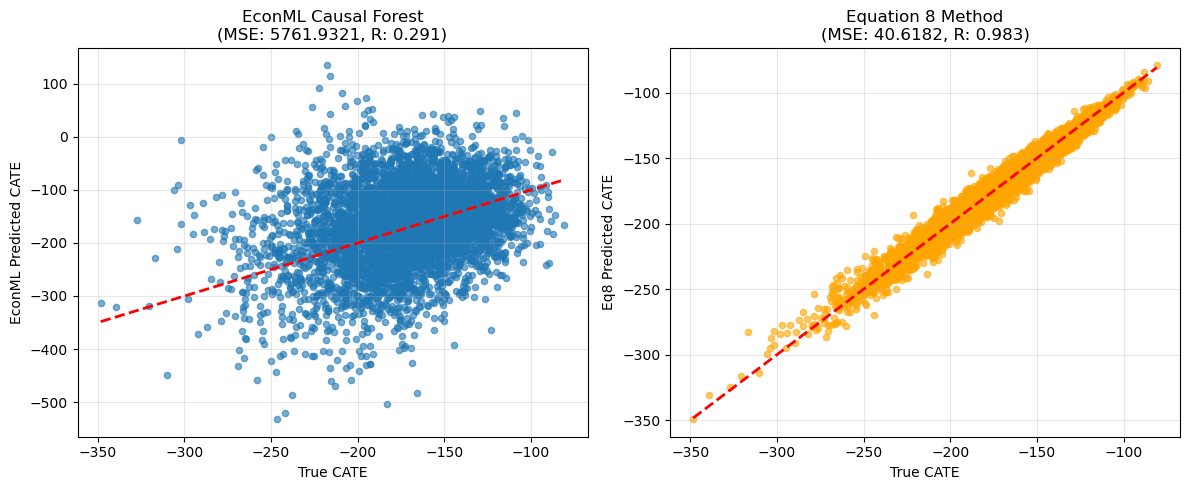

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Compute MSE and MAE for both methods
mse_econml = mean_squared_error(cate_true, cate_econml_pred)
mse_eq8 = mean_squared_error(cate_true, cate_eq8_pred)

mae_econml = mean_absolute_error(cate_true, cate_econml_pred)
mae_eq8 = mean_absolute_error(cate_true, cate_eq8_pred)

# Compute correlations
corr_econml = np.corrcoef(cate_true, cate_econml_pred)[0, 1]
corr_eq8 = np.corrcoef(cate_true, cate_eq8_pred)[0, 1]

# Print comparison results
print(f"\nMean Squared Error (MSE):")
print(f"  EconML Causal Forest: {mse_econml:.4f}")
print(f"  Equation 8 Method:    {mse_eq8:.4f}")

print(f"\nMean Absolute Error (MAE):")
print(f"  EconML Causal Forest: {mae_econml:.4f}")
print(f"  Equation 8 Method:    {mae_eq8:.4f}")

print(f"\nCorrelation with True CATE:")
print(f"  EconML Causal Forest: {corr_econml:.4f}")
print(f"  Equation 8 Method:    {corr_eq8:.4f}")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot: EconML vs True
axes[0].scatter(cate_true, cate_econml_pred, alpha=0.6, s=20)
axes[0].plot([cate_true.min(), cate_true.max()], [cate_true.min(), cate_true.max()], 'r--', lw=2)
axes[0].set_xlabel('True CATE')
axes[0].set_ylabel('EconML Predicted CATE')
axes[0].set_title(f'EconML Causal Forest\n(MSE: {mse_econml:.4f}, R: {corr_econml:.3f})')
axes[0].grid(True, alpha=0.3)

# Scatter plot: Equation 8 vs True
axes[1].scatter(cate_true, cate_eq8_pred, alpha=0.6, s=20, color='orange')
axes[1].plot([cate_true.min(), cate_true.max()], [cate_true.min(), cate_true.max()], 'r--', lw=2)
axes[1].set_xlabel('True CATE')
axes[1].set_ylabel('Eq8 Predicted CATE')
axes[1].set_title(f'Equation 8 Method\n(MSE: {mse_eq8:.4f}, R: {corr_eq8:.3f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()